# Clarke's experiment numerical circuit simulation for the full boxes

## Context

In this notebook we simulate Clarke's experiment (https://doi.org/10.1103/PhysRevA.63.040305) for unambiguous discrimination of single-photon polarization states with the addition of an ancilla photon in one of the input ports. For this purpose we use the *strawberry fields* package. We simulate the experiment for the three boxes.

## Output

- Numerical output photon distributions for the three boxes

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

import matplotlib.pyplot as plt

# set the random seed
np.random.seed(42)

In [18]:
#========= Simulation parameters ============

n_paths = 3
n_modes = n_paths*2
cutoff_dim = 2

#======== Initial State Preparation ==========

# Vacuum State Array
VacuumState = np.zeros([cutoff_dim] * n_modes, dtype='complex')

# One-photon maximum entropy state
MaxMixedState = np.zeros([cutoff_dim,cutoff_dim] * n_modes, dtype='complex')
MaxMixedState[1,1,0,0,0,0,0,0,0,0,0,0] = 1/2
MaxMixedState[0,0,1,1,0,0,0,0,0,0,0,0] = 1/2

# Add ancilla photon
MaxMixedState[0,0,0,0,0,0,1,1,0,0,0,0] = 1

MaxMixedState = DensityMatrix(MaxMixedState)

# Qubit state in path 0 generator, theta and phi are spherical coordinate angles in the Bloch sphere
def QubitState0(theta, phi):
    State = np.copy(VacuumState)
    
    State[1,0,0,0,0,0] = np.cos(theta/2)
    State[0,1,0,0,0,0] = np.sin(theta/2)*np.exp(1j*phi)
    
    return State

# Qubit state in path 1 generator, theta and phi are spherical coordinate angles in the Bloch sphere
def QubitState1(theta, phi):
    State = np.copy(VacuumState)
    
    State[0,0,1,0,0,0] = np.cos(theta/2)
    State[0,0,0,1,0,0] = np.sin(theta/2)*np.exp(1j*phi)
    
    return State

# Qubit state in path 2 generator, theta and phi are spherical coordinate angles in the Bloch sphere
def QubitState2(theta, phi):
    State = np.copy(VacuumState)
    
    State[0,0,0,0,1,0] = np.cos(theta/2)
    State[0,0,0,0,0,1] = np.sin(theta/2)*np.exp(1j*phi)
    
    return State

StateDict = {
    "H" : QubitState0(0., 0.),
    "V" : QubitState0(pi, 0.),
    "D" : QubitState0(pi/2, 0.),
    "A" : QubitState0(pi/2, pi),
    "L" : QubitState0(pi/2, pi/2),
    "R" : QubitState0(pi/2,-pi/2)
}

#============ Gates' Construction =============

SWAP = Interferometer(np.array([[0,1],[1,0]]))

def HWP(angle):
    x = np.cos(2*angle)
    y = np.sin(2*angle)
    return Interferometer(np.array([[x,y],[y,-x]]))

QWPV = Interferometer(np.exp(1j*pi/4)*np.array([[1,0],[0,-1j]]))

#============ Other parameters ===============

alpha = pi/8 # half-angle between states to discriminate
opt_wp4_angle = np.arcsin(np.tan(alpha))/2 # optimal WP4 angle for discrimination
N = 250 # half-number of photons per box

In [3]:
#=========== Circuit construction (for pure states) ============

PureStateProg = sf.Program(n_modes)
InitialState = PureStateProg.params('InitialState')

with PureStateProg.context as q:
    # prepare initial state
    Ket(InitialState) | q

    # apply gates
    HWP(alpha/2) | (q[0], q[1]) # WP0, for preparation of H and D into "standard" form
    #HWP(pi/2) | (q[0], q[1])
    SWAP | (q[1], q[3]) # PBS2 (Names follow the article convention)
    HWP(opt_wp4_angle) | (q[0], q[1]) # WP4
    SWAP | (q[1], q[5]) # PBS3
    HWP(pi/4) | (q[2] , q[3]) # WP5
    SWAP | (q[3], q[5]) # PBS5
    HWP(3*pi/8) | (q[2], q[3]) # WP6

    # measure
    MeasureFock() | q

#=========== Circuit construction (for maximum entropy state) ============
    
MixedStateProg = sf.Program(n_modes)

with MixedStateProg.context as q:
    # prepare initial state
    MaxMixedState | q

    # apply gates
    HWP(alpha/2) | (q[0], q[1]) # WP0, for preparation of H and D into "standard" form
    SWAP | (q[1], q[3]) # PBS2
    HWP(opt_wp4_angle) | (q[0], q[1]) # WP4
    SWAP | (q[1], q[5]) # PBS3
    HWP(pi/4) | (q[2] , q[3]) # WP5
    SWAP | (q[3], q[5]) # PBS5
    HWP(3*pi/8) | (q[2], q[3]) # WP6

    # measure
    MeasureFock() | q
    
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff_dim})

# Box A Simulation

In [4]:
photons = np.array(["H"]*N + ["V"]*N)
np.random.shuffle(photons)

samples = []

for s in photons:
    init_state = StateDict[s] + QubitState1(pi,pi)
    result = eng.run(PureStateProg, args={'InitialState': init_state})
    samples.append(result.samples[0])
    
freqsA = np.array(samples).sum(axis=0)

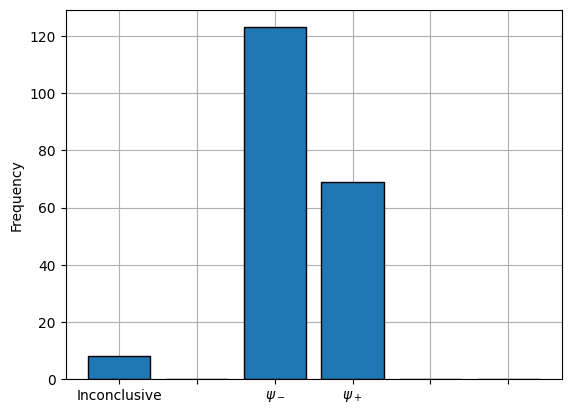

In [6]:
plt.figure()
plt.bar(range(6), freqsA, ec='k',zorder=2)
plt.grid(zorder=1)
plt.xticks(range(6), ["Inconclusive","",r"$\psi_-$",r"$\psi_+$","",""])
plt.ylabel("Frequency")
plt.show()

# Box B Simulation

In [7]:
photons = np.array(["D"]*N + ["A"]*N)
np.random.shuffle(photons)

samples = []

for s in photons:
    init_state = StateDict[s] + QubitState1(pi,pi)
    result = eng.run(PureStateProg, args={'InitialState': init_state})
    samples.append(result.samples[0])
    
freqsB = np.array(samples).sum(axis=0)

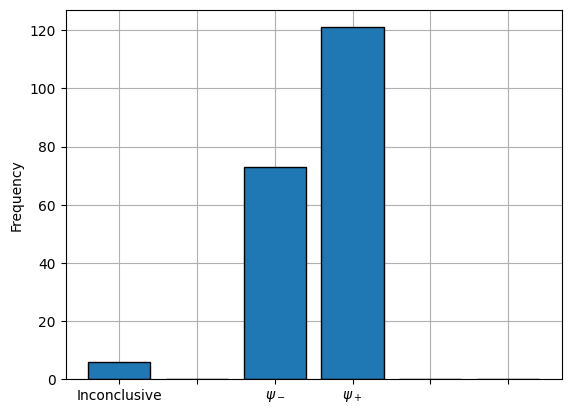

In [8]:
plt.figure()
plt.bar(range(6), freqsB, ec='k',zorder=2)
plt.grid(zorder=1)
plt.xticks(range(6), ["Inconclusive","",r"$\psi_-$",r"$\psi_+$","",""])
plt.ylabel("Frequency")
plt.show()

# Box C Simulation

In [9]:
samples = []

for s in photons:
    result = eng.run(MixedStateProg)
    samples.append(result.samples[0])
    
freqsC = np.array(samples).sum(axis=0)

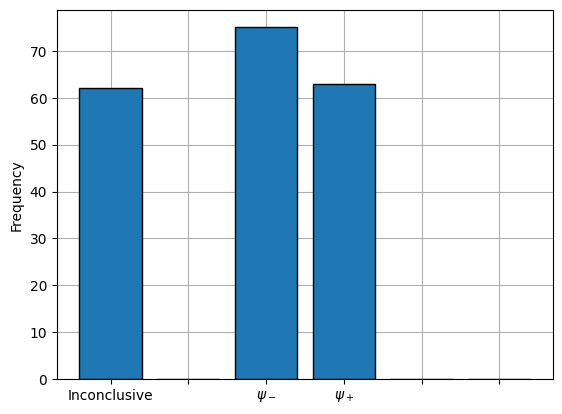

In [10]:
plt.figure()
plt.bar(range(6), freqsC, ec='k',zorder=2)
plt.grid(zorder=1)
plt.xticks(range(6), ["Inconclusive","",r"$\psi_-$",r"$\psi_+$","",""])
plt.ylabel("Frequency")
plt.show()

# All boxes graphs

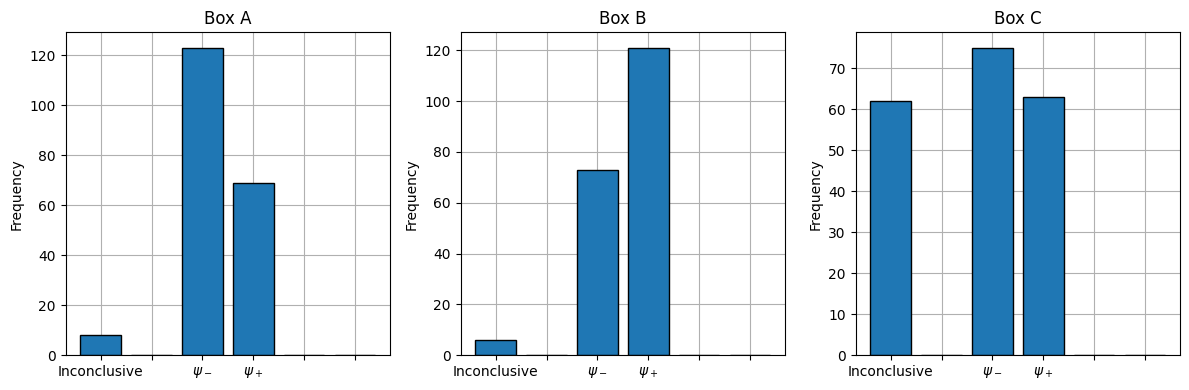

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].set_title("Box A")
ax[0].bar(range(6), freqsA, ec='k',zorder=2)
ax[0].grid(zorder=1)
ax[0].set_xticks(range(6), ["Inconclusive","",r"$\psi_-$",r"$\psi_+$","",""])
ax[0].set_ylabel("Frequency")

ax[1].set_title("Box B")
ax[1].bar(range(6), freqsB, ec='k',zorder=2)
ax[1].grid(zorder=1)
ax[1].set_xticks(range(6), ["Inconclusive","",r"$\psi_-$",r"$\psi_+$","",""])
ax[1].set_ylabel("Frequency")

ax[2].set_title("Box C")
ax[2].bar(range(6), freqsC, ec='k',zorder=2)
ax[2].grid(zorder=1)
ax[2].set_xticks(range(6), ["Inconclusive","",r"$\psi_-$",r"$\psi_+$","",""])
ax[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()